In [2]:
# install and test tensorflow env on my machine MacM1: https://www.youtube.com/watch?v=5DgWvU0p2bk
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import platform

print(f"Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"Numpy {np.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Platform: macOS-12.4-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
Pandas 1.5.0
Scikit-Learn 1.1.2
Numpy 1.23.2
GPU is available


In [2]:
from pathlib import Path
from PIL import Image
import albumentations as aug
import random
from matplotlib import pyplot as plt

In [3]:
import base64
import json
import os

import time
from io import BytesIO


import albumentations as aug
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import requests
import tensorflow as tf
from dotenv import dotenv_values, load_dotenv


from tqdm import tqdm

ModuleNotFoundError: No module named 'plotly'

# Loading the data and Creating 8 classes annotation
## Data description
After we downloaded the Cityscapes dataset we discover it's content and give some breaf introduction here.

The folder dataset containes the folowing :

 - leftImg8bit : the images of the dataset, I rename it to images/
 - gtFine/ : contains the images, I rename this folder into masks/
 - test/, train/ and val/ : contains the the three splits of the dataset
 - berlin/, frankfurt/, munich/, ... : contains the images that corresponds to different cities
 - *_gtFine_color.png : contains the labels colors
 - *_gtFine_instanceIds.png : contains the instance ids
 - *_gtFine_labalIds.png : contains the label ids
 - *_gtFine_polygons.json : contains the polygon shapes
 

We are not going to use the polygon shapes, but we will use the instance ids to build the ground truth images.

The dataset contains :
 - 2975 train images
 - 500 validation images
 - 1525 test images

According to the Cityscapes dataset documentation, the images are of size 2048x1024 and are in RGB format.

We will not use the object labels (32 labels), but the 8 label categories : "void", "flat", "construction", "object", "nature", "sky", "human" and "vehicle".

In [5]:
# Let's load the images 
data_path = Path("data")
images_path = Path(data_path, "images")
masks_path = Path(data_path, "masks")

In [6]:
# Train dataset
train_input_img_paths = sorted(
    Path(images_path, "train").glob("**/*_leftImg8bit.png")
)
train_label_ids_img_paths = sorted(
    Path(masks_path, "train").glob("**/*_gtFine_labelIds.png")
)
train_label_color_img_paths = sorted(
    Path(masks_path, "train").glob("**/*_color.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(images_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_ids_img_paths = sorted(
    Path(masks_path, "val").glob("**/*_gtFine_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(masks_path, "val").glob("**/*_color.png")
)

# Test dataset
test_input_img_paths = sorted(
    Path(images_path, "test").glob("**/*_leftImg8bit.png")
)
test_label_ids_img_paths = sorted(
    Path(masks_path, "test").glob("**/*_gtFine_labelIds.png")
)
test_label_colors_img_paths = sorted(
    Path(masks_path, "test").glob("**/*_color.png")
)

In [7]:
print('We have {0} train images'.format(len(train_input_img_paths)))
print('We have {0} validation images'.format(len(val_input_img_paths)))
print('We have {0} test images'.format(len(test_input_img_paths)))

We have 2975 train images
We have 500 validation images
We have 1525 test images


Next we take a random image and try to understand each file from the data.

In [21]:
rand_idx = np.random.randint(0, len(val_input_img_paths))
image_id = (
    str(val_input_img_paths[rand_idx])
    .split("/")[-1]
    .replace("_leftImg8bit.png", "")
)
img = np.array(Image.open(val_input_img_paths[rand_idx]))
ids_img = np.array(np.array(Image.open(val_label_ids_img_paths[rand_idx])))
img_size = img.shape
color_img = np.array(np.array(Image.open(val_label_colors_img_paths[rand_idx])))
ids_img_size = ids_img.shape
color_img_size = color_img.shape

print('The size image is: {0}'.format(img_size))
print('The size ids image is: {0}'.format(ids_img_size))
print('The size color image is: {0}'.format(color_img_size))

The size image is: (1024, 2048, 3)
The size ids image is: (1024, 2048)
The size color image is: (1024, 2048, 4)


Note that 
 - each image has the size of (1024, 2048) with dimension 3 that is the RGB.
 - the label_ids images sizes are (1024, 2048) that tells us the label associated to that pixel
 - color image has the size of (1024, 2048) with dimension 4. The first 3 dimensions is the RGB and the fourth layer is the alpha chanel which is added to allow the transparency of the image (it does not change the color of the pixel). Also, we note that this is equal to 255 for all the times, there is why we can delete it.
 
Also we observe there is 1024 * 2048 = 2097152 pixels in the image.

Let us see the color of the first pixel in the image

In [22]:
img[0,0,:]

array([57, 62, 50], dtype=uint8)

Let us see the ids of the first pixel in the labelIds image. This correspons to 3, that meens that the first pixel is attributed to the **void** cathegory.

In [23]:
ids_img[0,0]

3

In [24]:
color_img = color_img[:,:,:3]
color_img_size = color_img.shape
print('The size color image is: {0}'.format(color_img_size))

The size color image is: (1024, 2048, 3)


In [25]:
1024*2048

2097152

In [26]:
color_img.reshape(-1,3).shape

(2097152, 3)

## Colors in the image

In [27]:
colours, counts = np.unique(color_img.reshape(-1,3), axis=0, return_counts=1)
for j in range(len(colours)):
    print('{0}/{1}:{2}'.format(j, colours[j], counts[j]))

0/[0 0 0]:117201
1/[ 0  0 70]:113184
2/[  0   0 142]:271805
3/[70 70 70]:298647
4/[ 70 130 180]:67482
5/[107 142  35]:410589
6/[111  74   0]:14506
7/[128  64 128]:735503
8/[153 153 153]:7812
9/[220  20  60]:17648
10/[220 220   0]:8486
11/[244  35 232]:34001
12/[250 170  30]:288


## Image anotation

In [28]:
def count_label_anotation(ann_img):
    colours, counts = np.unique(ann_img, return_counts=1)
    for j in range(len(colours)):
        print('{0}/{1}:{2}'.format(j, colours[j], counts[j]))

In [29]:
count_label_anotation(ids_img)

0/1:81534
1/3:31634
2/4:4033
3/5:14506
4/7:735503
5/8:34001
6/11:298647
7/17:7812
8/19:288
9/20:8486
10/21:410589
11/23:67482
12/24:17648
13/26:271805
14/27:113184


## Transform 8 classes annotation

In [30]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
 }

cats_replace = {0: [0, 1, 2, 3, 4, 5, 6],
 1: [7, 8, 9, 10],
 2: [11, 12, 13, 14, 15, 16],
 3: [17, 18, 19, 20],
 4: [21, 22],
 5: [23],
 6: [24, 25],
 7: [26, 27, 28, 29, 30, 31, 32, 33, -1]
 }

cats_id = {
 'void': (0),
 'flat': (1),
 'construction': (2),
 'object': (3),
 'nature': (4),
 'sky': (5),
 'human':(6),
 'vehicle': (7)
}

cats_colors = {
 'void': (0,0,0),
 'flat': (50,50,50),
 'construction': (150,150,150),
 'object': (255,0,0),
 'nature': (0,255,0),
 'sky': (0,0,255),
 'human':(200,200,0),
 'vehicle': (150,0,200)
}

In [31]:
mask_labelids = pd.DataFrame(ids_img)
for new_value, old_value in cats_replace.items():
    mask_labelids = mask_labelids.replace(old_value, new_value);
mask_labelids = mask_labelids.to_numpy()

In [32]:
count_label_anotation(mask_labelids)

0/0:131707
1/1:769504
2/2:298647
3/3:16586
4/4:410589
5/5:67482
6/6:17648
7/7:384989


Observe that there is no sky annotated in the picture. Let us show the original picture with the annotation picture.

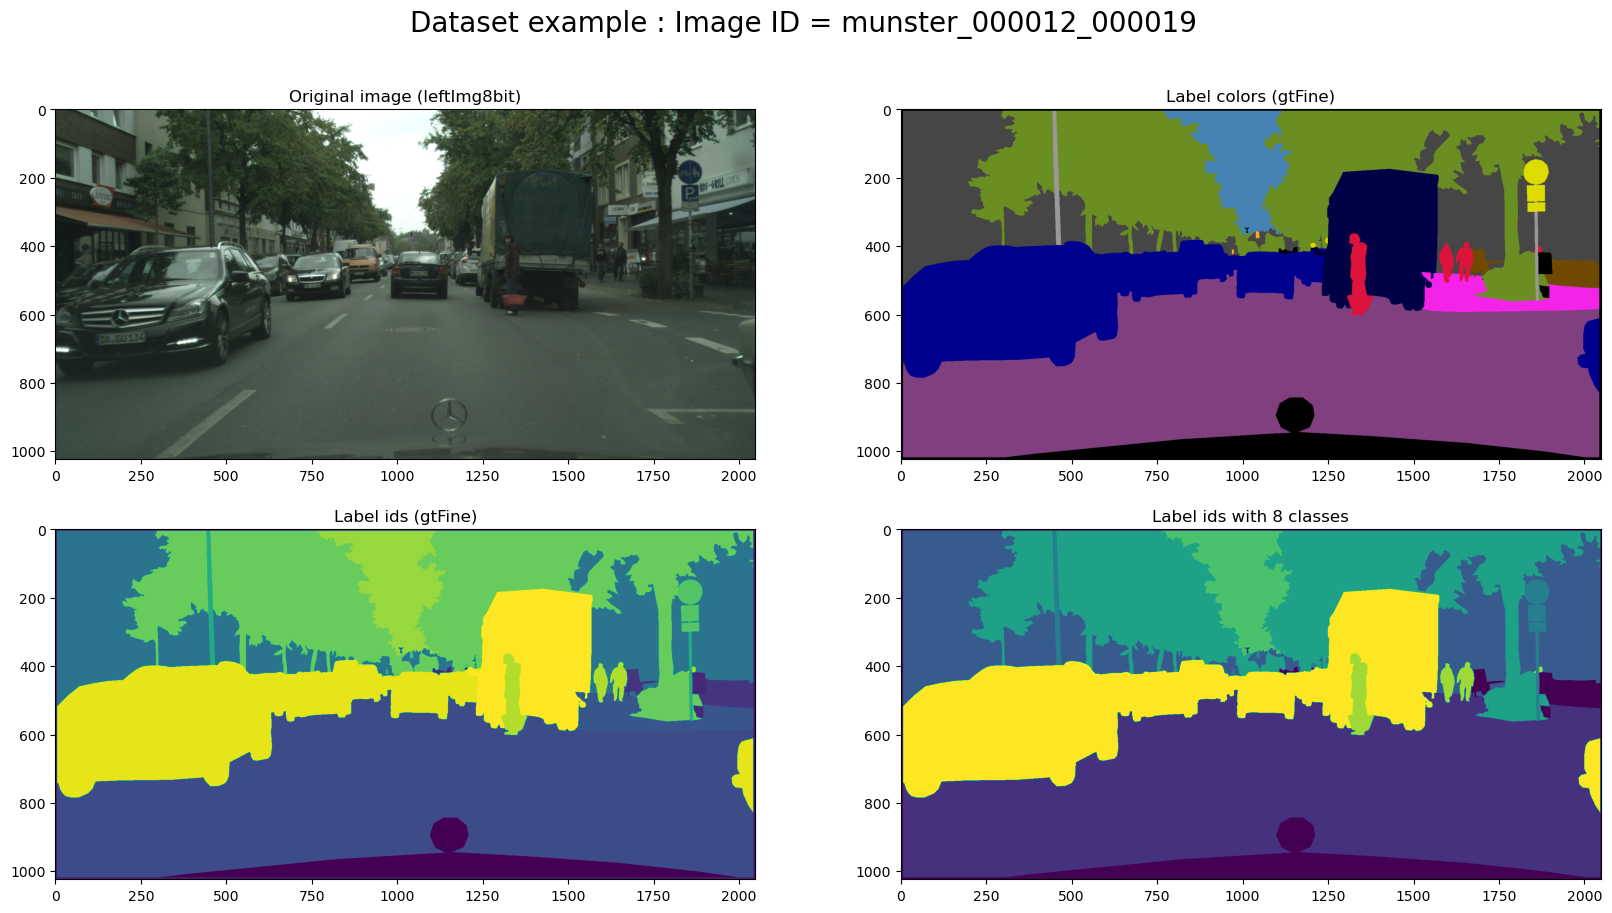

In [33]:
# plot images
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(20, 10),
)
fig.suptitle(f"Dataset example : Image ID = {image_id}", fontsize=20)

ax[0, 0].title.set_text("Original image (leftImg8bit)")
ax[0, 0].imshow(img)

ax[0, 1].title.set_text("Label colors (gtFine)")
ax[0, 1].imshow(color_img)

ax[1, 0].title.set_text("Label ids (gtFine)")
ax[1, 0].imshow(np.array(ids_img))

ax[1, 1].title.set_text("Label ids with 8 classes")
ax[1, 1].imshow(np.array(mask_labelids))

plt.show()

In [44]:
ids_img

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=uint8)

# Augmentation images
Let us now see how we can augment the images. We will take the original image and the label ids with 8 annotated classes and we will use the albumentations class to augment the images.

In [41]:
transform = aug.Compose(
    [
        aug.OneOf(  # Color augmentations
            [
                aug.RandomBrightnessContrast(),
                aug.RandomGamma(),
                aug.RandomToneCurve(),
            ]
        ),
        aug.OneOf(  # Camera augmentations
            [
                aug.MotionBlur(),
                aug.GaussNoise(),
            ]
        ),
        aug.OneOf(  # Geometric augmentations
            [
                aug.HorizontalFlip(),
                aug.RandomCrop(
                    width=int(img_size[1] / random.uniform(1.0, 2.0)),
                    height=int(img_size[0] / random.uniform(1.0, 2.0)),
                ),
                aug.SafeRotate(
                    limit=15,
                ),
            ]
        ),
    ]
)

#img = np.array(Image.open(val_input_img_paths[rand_idx]))
#mask = np.array(Image.open(val_label_ids_img_paths[rand_idx]))

augmented = transform(
    image=img,
    mask=mask_labelids,
)

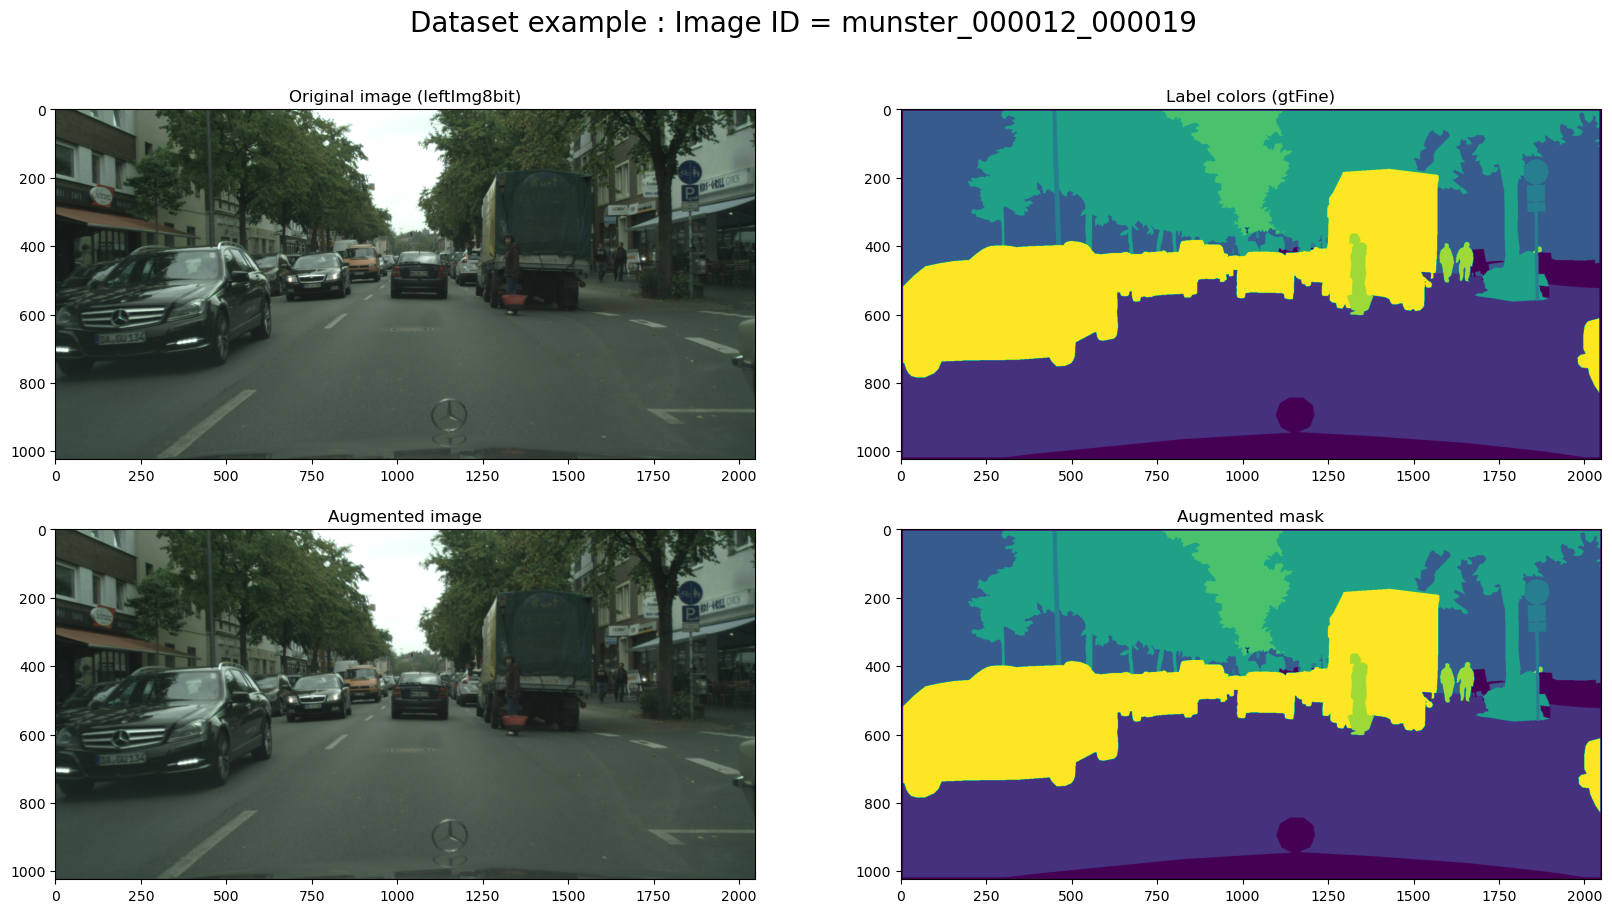

In [42]:
# plot images
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(20, 10),
)
fig.suptitle(f"Dataset example : Image ID = {image_id}", fontsize=20)

ax[0,0].title.set_text("Original image (leftImg8bit)")
ax[0,0].imshow(img)

ax[0,1].title.set_text("Label colors (gtFine)")
ax[0,1].imshow(np.array(mask_labelids))

ax[1,0].title.set_text("Augmented image")
ax[1,0].imshow(np.array(augmented["image"]))

ax[1,1].title.set_text("Augmented mask")
ax[1,1].imshow(np.array(augmented["mask"]))

plt.show()

Observe an augmantation as a crop is done here.

https://github.com/divamgupta/image-segmentation-keras